In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import re


def StraightLine(x, m, c):
    y = m * x + c
    return y
def do_fit(Lmeas,dLmeas,mode,title):
    '''
    Do a fit and plot the graphs (with error bars) given Lmeas (measurements array), dLmeas (uncertainties array), mode (modes array), and title of graph
    '''
    line, cov = curve_fit(StraightLine, mode, Lmeas, sigma=dLmeas, absolute_sigma=True)
    m = line[0]
    c = line[1]
    error_m = np.sqrt(cov[0,0])
    error_c = np.sqrt(cov[1,1])
    # Compute chi-squared
    Lfit = StraightLine(mode, *line)
    chisq = ((Lmeas-Lfit)/dLmeas)**2
    print(f'Chi-squared: {chisq.sum():.2f},  Number of degrees of freedom: {len(Lmeas)-2}')
    print(f'Reduced chi-squared: {chisq.sum()/(len(Lmeas)-2):.3f}')
    print(f'The slope is {m:.5f} +/- {error_m:.5f}')
    print(f'The intercept is {c:.4f} +/- {error_c:.4f}')
    
    '''
    # new code from template (might have to adjust this to m instead of cm)
    wavelength = m*4
    vel = freq*wavelength
    dWv = 0.5/100.
    dVel = np.sqrt((error_m/m)**2+(dWv/wavelength)**2)
    print(f'Velocity estimate: {vel} +/- {dVel} m/s')
    Terr = 0.8
    T = 297.8
    vel_est = 20.1*np.sqrt(T)
    dVelest = vel_est*0.5*(Terr/T)
    print(f'Velocity from formula (20.1*sqrt(T)): {vel_est} +/- {dVelest} m/s')
    ##########
    '''
    
    plt.figure(figsize=(10, 6))
    plt.rc('font', size=18)

    # Set boundaries for the 2-D scatter plot with error bars
    xstart = 1
    xstop  = len(mode)
    #plt.xlim(xstart, xstop)
    #plt.ylim(-0.05, 1)

    # Plot the data
    plt.errorbar(mode, Lmeas, yerr=dLmeas, fmt='bo')

    # Compute best-fit values
    xvalues = np.linspace(xstart, xstop, 100)
    yvalues_fit = StraightLine(xvalues, *line)

    # Plot the fit results
    plt.plot(xvalues, yvalues_fit)
    #plt.legend(fontsize=20)

    # Add title and axis labels
    plt.title(title)
    plt.ylabel('Position from center (cm)')
    plt.xlabel('Mode Number')
    #plt.ylim(0, 1.2)
    #ylines = np.array([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])
    #plt.hlines(ylines, xmin=xstart, xmax=xstop, linestyle='dotted', linewidth=0.5, color='green')

    plt.show()
    #plt.savefig(f'{title}-plot.png')
    
    # Compute residuals, i.e. difference between the measured lengths and the best-fit lengths
    Lres = Lmeas - Lfit

    # Plot the residuals
    plt.figure(figsize=(8, 5))
    #plt.xlim(xstart, xstop)
    #plt.ylim(-.015, .015)
    plt.errorbar(mode, Lres, yerr=dLmeas, fmt='bo')
    plt.rc('font', size=12)
    plt.title(fr'Fit residuals ($\chi^2_{{reduced}}$={chisq.sum()/(len(Lmeas)-2):.3f})')
    plt.xlabel('Mode number')
    plt.ylabel('$L_{meas}$ - $L_{fit}$ (cm)')
    plt.axhline(y=0.0, color='g', linestyle='--')
    plt.show()
    #plt.savefig(f'{title}-residuals.png')
    return (m,error_m)
    


Chi-squared: 0.80,  Number of degrees of freedom: 2
Reduced chi-squared: 0.400
The slope is 0.24000 +/- 0.02236
The intercept is 0.0500 +/- 0.0612


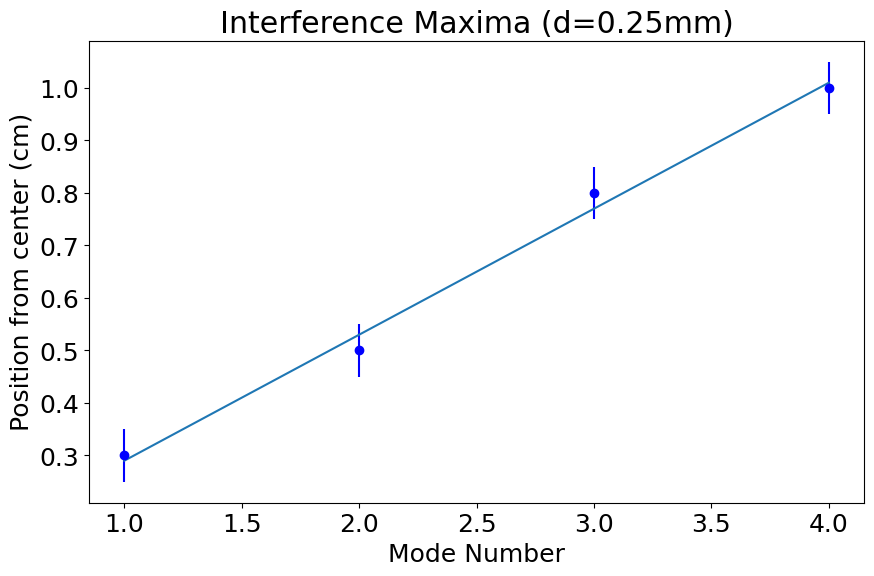

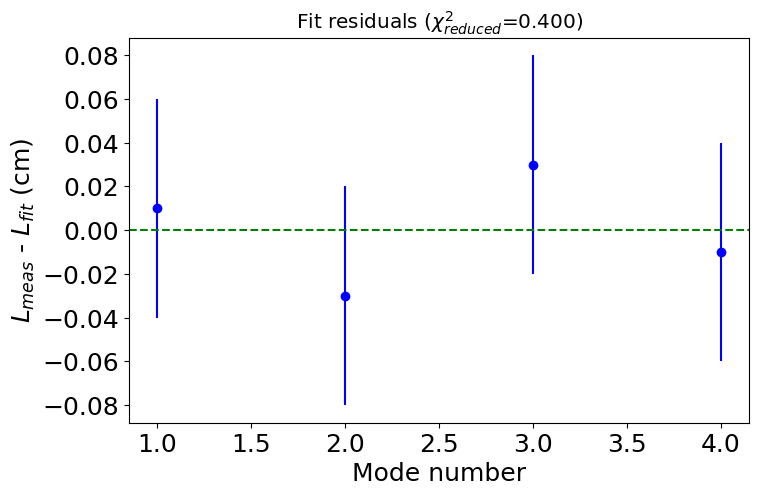

Chi-squared: 2.80,  Number of degrees of freedom: 2
Reduced chi-squared: 1.400
The slope is 1.69000 +/- 0.01336
The intercept is -0.0000 +/- 0.0000


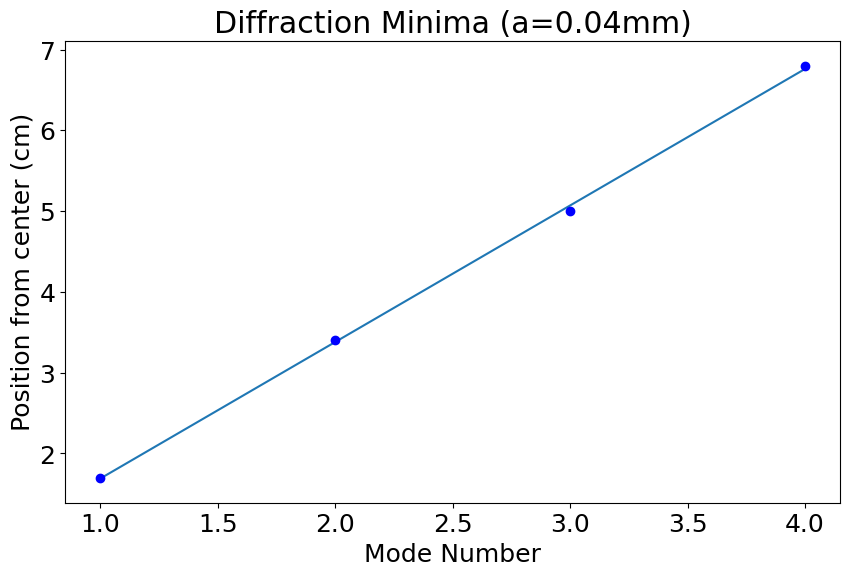

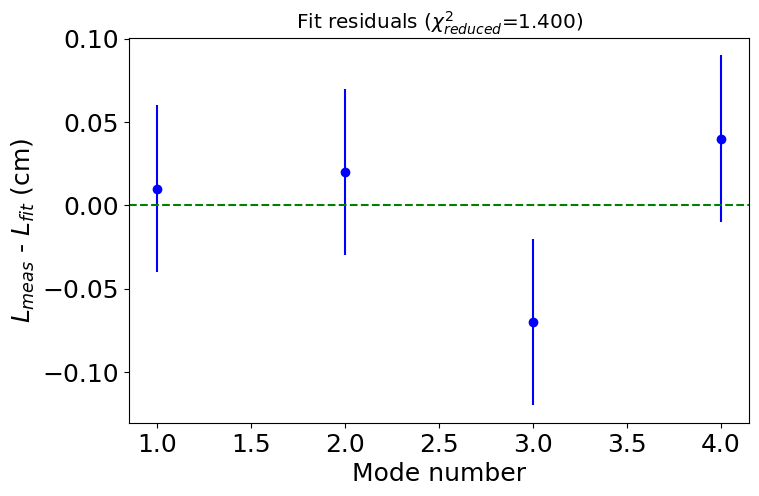

Chi-squared: 0.80,  Number of degrees of freedom: 2
Reduced chi-squared: 0.400
The slope is 0.14000 +/- 0.02236
The intercept is -0.0500 +/- 0.0612


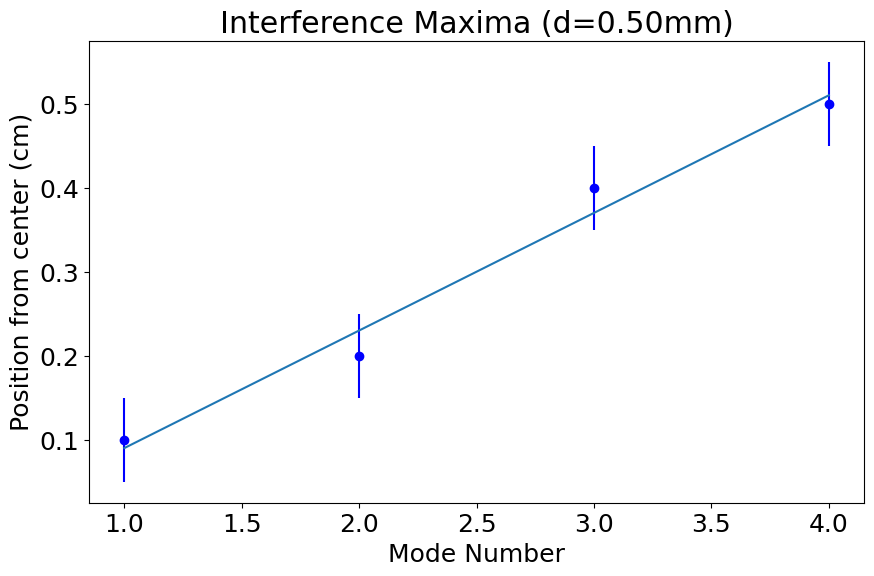

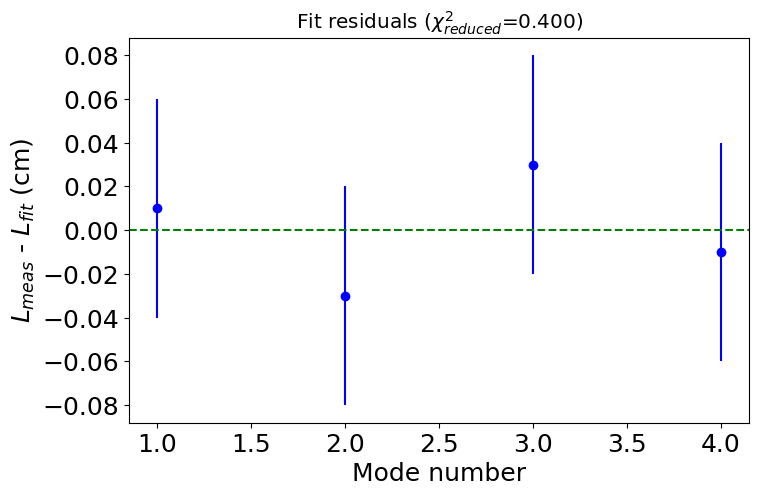

Chi-squared: 0.22,  Number of degrees of freedom: 2
Reduced chi-squared: 0.108
The slope is 1.83514 +/- 0.02325
The intercept is -0.1378 +/- 0.0662


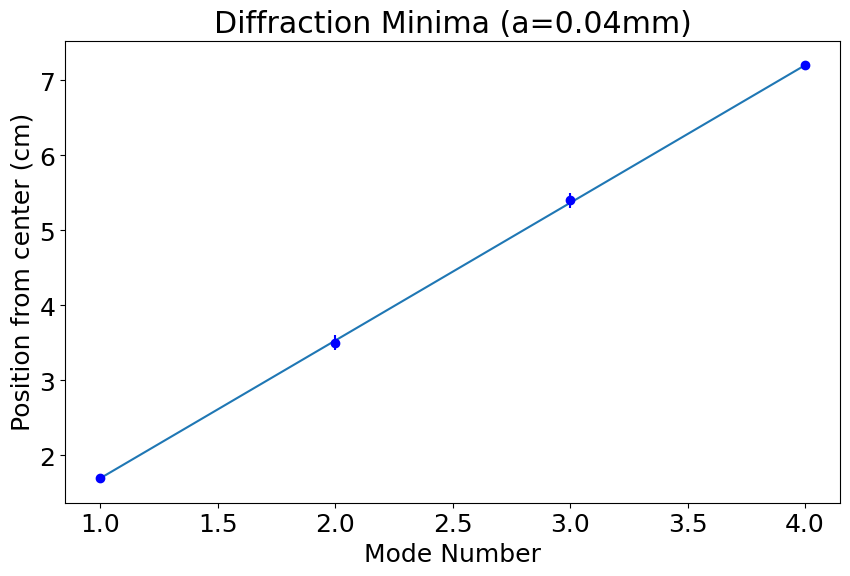

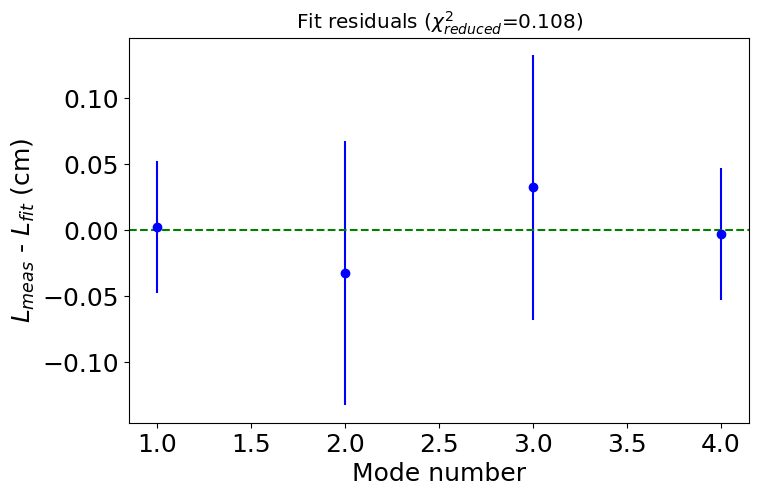


---------First part of exp-----
Predictions for the wavelength of light used (nm)

light spot & .25d: (631.5789467148614, 58.84483032767351) nm
dark spot & .25d: (711.5789473690547, 5.639002999604669) nm
light spot & .50d: (666.6666666577327, 106.48131553382186) nm
dark spot & .50d: (699.0990985684535, 8.881955862542304) nm


"\nmodes = np.array([1,2,3,4])\nplt.plot(modes,data_25[0],'bo',label='.25mm light spots')\nplt.plot(modes,data_50[0],'ro',label='.50mm light spots')\nplt.xlabel('Mode Number')\nplt.legend(loc='best')\nplt.show()\n\nplt.plot(modes,data_25[1],'bo',label='.25mm dark spots')\nplt.plot(modes,data_50[1],'ro',label='.50mm dark spots')\nplt.legend(loc='best')\nplt.show()\n"

In [74]:
# format is [[light spots data],[dark spots]]


# this is data with d=0.25mm
# D(cm) = 95+/- 0.05
data_25 = np.array([[0.3,0.5,0.8,1],
                   [1.7,3.4,5,6.8]])

# this is data with d=0.50mm
# D(cm) = 105 +/- 0.1
data_50 = np.array([[0.1,0.2,0.4,0.5],
                    [1.7,3.5,5.4,7.2]])

def find_wv(data,unc,D,uncD,d=None,a=None):
    '''
    find wavelength in nm given (all in cm) data ([[],[],[],[]]), uncertainty, D, and either d or a
    set a (cm) if it's a min (dark spots)
    set d (cm) if it's a max (light spots)
    '''
    modes = np.arange(1,len(data)+1)
    slope,uncer = (0,0)
    nanowv = 0
    unc_nanowv = 0
    if(d==None): # then we're assuming a is set and we're finding from dark spots (minimum values)
        slope,uncer = do_fit(data,unc,modes,(f'Diffraction Minima (a={a*10:.2f}mm)'))
        wv_min = slope*a/D
        nanowv = wv_min/(1e-7)
        unc_wv = wv_min*np.sqrt((uncD/D)**2+(uncer/slope)**2) # assuming no uncertainty in a
        unc_nanowv = unc_wv/(1e-7)
    elif(a==None): # then we're assuming d is set and we're finding from light spots (max values)
        slope,uncer = do_fit(data,unc,modes,(f'Interference Maxima (d={d*10:.2f}mm)'))
        wv_min = slope*d/D
        nanowv = wv_min/(1e-7)
        unc_wv = wv_min*np.sqrt((uncD/D)**2+(uncer/slope)**2) # assuming no uncertainty in d
        unc_nanowv = unc_wv/(1e-7)
    
    return (nanowv,unc_nanowv)


unc = np.full(len(data_25[0]),0.05) # assuming constant uncertainty between values
wv_25_d = find_wv(data_25[0],unc,95,0.05,d=0.25/10)

unc = np.full(len(data_25[1]),0.05) # assuming constant uncertainty between values
wv_25_a = find_wv(data_25[1],unc,95,0.05,a=0.04/10)

unc = np.full(len(data_50[0]),0.05) 
wv_50_d = find_wv(data_50[0],unc,105,0.1,d=0.5/10)

unc = np.array([0.05,0.1,0.1,0.05])
wv_50_a = find_wv(data_50[1],unc,105,0.1,a=0.04/10)

print("\n---------First part of exp-----\nPredictions for the wavelength of light used (nm)\n")
print(f'light spot & .25d: {wv_25_d} nm')
print(f'dark spot & .25d: {wv_25_a} nm')
print(f'light spot & .50d: {wv_50_d} nm')
print(f'dark spot & .50d: {wv_50_a} nm')

'''
modes = np.array([1,2,3,4])
plt.plot(modes,data_25[0],'bo',label='.25mm light spots')
plt.plot(modes,data_50[0],'ro',label='.50mm light spots')
plt.xlabel('Mode Number')
plt.legend(loc='best')
plt.show()

plt.plot(modes,data_25[1],'bo',label='.25mm dark spots')
plt.plot(modes,data_50[1],'ro',label='.50mm dark spots')
plt.legend(loc='best')
plt.show()
'''

In [86]:
def calc_weighted_average(values,uncer):
    '''
    Calculate weighted average given list of values and list of uncertainties corresponding to those values
    like so: (values=[data1,data2,data3],uncer=[unc_data1,unc_data2,unc_data3])
    '''
    
    weights = 1/(uncer**2)
    avg = np.sum(values*weights)/np.sum(weights)
    unc = np.sqrt(1/(np.sum(weights)))
    return (avg,unc)


print('\nWeighted average of Wavelength')

vals = np.array([wv_25_d[0],wv_25_a[0],wv_50_d[0],wv_50_a[0]])
uncers = np.array([wv_25_d[1],wv_25_a[1],wv_50_d[1],wv_50_a[1]])

final_wv_nm = calc_weighted_average(vals,uncers)
print(f'{final_wv_nm} nm')



Weighted average of Wavelength
(707.4159299827779, 4.740392232800952) nm




------ second part, predictions for the width (a in cm/mm) of hair -----

Chi-squared: 0.30,  Number of degrees of freedom: 3
Reduced chi-squared: 0.100
The slope is 0.73000 +/- 0.03162
The intercept is 0.6500 +/- 0.1049


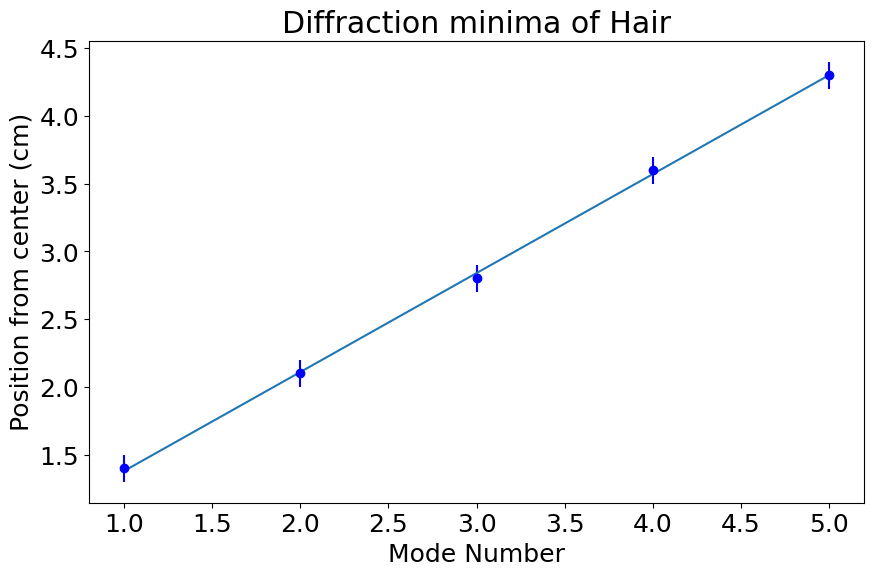

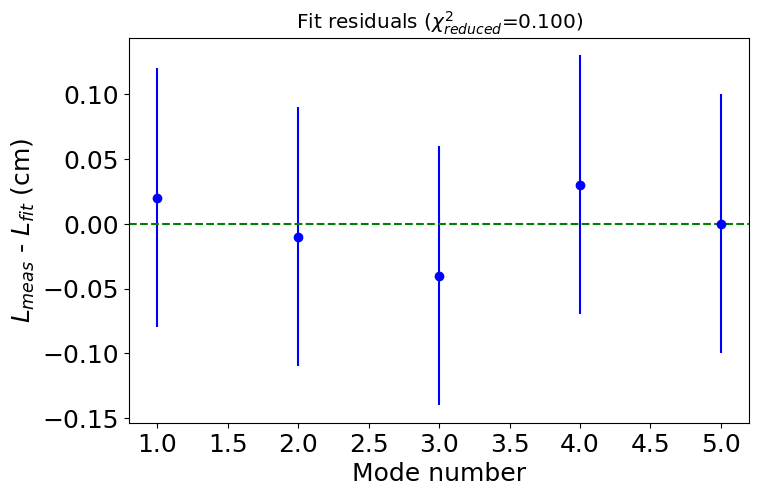

Hair prediction size (a in mm): (0.09894132390589025, 0.004338085984565711) mm


In [108]:
### calc for a of hair

print('\n\n------ second part, predictions for the width (a in cm/mm) of hair -----\n')


### D = 102.1	0.1 cm
y_vals_for_hair = np.array([1.4,2.1,2.8,3.6,4.3])
modes = np.arange(1,len(y_vals_for_hair)+1)

### find a from slope given lambda and D
uncer = np.full(len(y_vals_for_hair),0.1)
slope,unc = do_fit(y_vals_for_hair,uncer,modes,'Diffraction minima of Hair') 

final_wv_cm = np.zeros(len(final_wv_nm))
final_wv_cm[0] = final_wv_nm[0]*1e-7
final_wv_cm[1] = final_wv_nm[1]*1e-7
hair_a = final_wv_cm[0]*102.1/slope
hair_unc = a*np.sqrt((final_wv_cm[1]/final_wv_cm[0])**2+(0.1/102.1)**2+(unc/slope)**2)

hair_a*=10
hair_unc*=10

print(f'Hair prediction size (a in mm): {hair_a,hair_unc} mm')


In [127]:
### Finding sigma for all values based on reference values

def do_sig(val1,valerr1,val2,valerr2):
    '''
    Find sigma of 2 values (see if 2 values are in agreement or not)
    - Anything $\sigma<1.0$ is in agreemnt
    - 1<sigma<2 is a gray area
    - sigma>3.0 the values do not agree
    '''
    uncer = np.sqrt((valerr1**2)+(valerr2**2))
    diff = np.absolute(val1-val2)
    return (diff/uncer)


print('(https://science.nasa.gov/ems/09_visiblelight/)\n reference for red light prediction: red has the longest wavelength, at around 700 nanometers')

goal = 700
uncgoal = 5

wv_sig = do_sig(final_wv_nm[0],final_wv_nm[1],goal,uncgoal)
print(f'Sigma for 1st part (final_wv_nm: {final_wv_nm[0]} nm, vs 700nm): {wv_sig:.2f}')


print('\n(https://hairmax.co.uk/blogs/news/how-thick-is-a-strand-of-hair-1#:~:text=Europeans%20consider%20hair%20with%20a,is%200.08%20to%200.12%20mm.)\nReference for hair prediction:Europeans consider hair with a diameter of 0.04 to 0.06 mm as thin, hair with a diameter between 0.06 and 0.08 mm as normal, and hair with a diameter between 0.08 and 0.1 mm as thick')

goal = 0.09 #assuming the hair is thick
uncgoal = 0.005
hair_sig = do_sig(hair_a,hair_unc,goal,uncgoal)
print(f'Best case Sigma for 2nd part (hair width: {hair_a}mm, vs ~{goal}mm): {hair_sig:.2f}')

goal = 0.08 #assuming the hair is 'normal'
hair_sig = do_sig(hair_a,hair_unc,goal,uncgoal)
print(f'Likely case Sigma for 2nd part (hair width: {hair_a}mm, vs ~{goal}mm): {hair_sig:.2f}')

(https://science.nasa.gov/ems/09_visiblelight/)
 reference for red light prediction: red has the longest wavelength, at around 700 nanometers
Sigma for 1st part (final_wv_nm: 707.4159299827779 nm, vs 700nm): 1.08

(https://hairmax.co.uk/blogs/news/how-thick-is-a-strand-of-hair-1#:~:text=Europeans%20consider%20hair%20with%20a,is%200.08%20to%200.12%20mm.)
Reference for hair prediction:Europeans consider hair with a diameter of 0.04 to 0.06 mm as thin, hair with a diameter between 0.06 and 0.08 mm as normal, and hair with a diameter between 0.08 and 0.1 mm as thick
Best case Sigma for 2nd part (hair width: 0.1mm, vs ~0.09mm): 1.51
Likely case Sigma for 2nd part (hair width: 0.1mm, vs ~0.08mm): 3.02


In [120]:
### Report writing

def convert_to_latex(inp, sep):
    '''
    Function to create a table from inputted values separated by sep variable 
    (varible must be character escapted like \t for tab-separated), or just ',' for csv
    Input: inp = input string, full input string, sep = separator value
    '''
    ###### input #######
    #### format is: value \t error \t value \t error (etc)
    ####################
    output = ""
    out = re.split(fr'{sep}+', inp.rstrip(f'{sep}'))
    #print(out)
    c=0
    for i in range(0,int(len(out)/2)):
        iout = f'${out[c]}\pm{out[c+1]}$&'
        output+=iout
        c+=2
    return output




data = '''95	0.05'''
lines = data.split("\n")
for i in lines:
    print(convert_to_latex(i,'\t'))


$95\pm0.05$&
